In [1]:
latex_dir = 'LaTex/img/'
EXPORT_FOR_LATEX = True

def plot_images(plot, figname=None):
    if EXPORT_FOR_LATEX:
        plt.savefig(latex_dir+figname+'.pdf', bbox_inches='tight')
    else:
        plot.show()

In [2]:
import pymc3 as pm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import seaborn as sns
from theano import shared


# Galapagos
A data frame with 30 observations on the following 8 variables.

* Island: a character vector indicating the island
* Total: total number of observed species
* Native: number of native species
* Area: area (km2)
* Elev: elevation (m)
* DistNear: distance from nearest island (km)
* DistSC: distance from Santa Cruz (km)
* AreaNear: area of nearest island (km)

In [29]:
colors = ['#FF8168','#4F86FF','#2284B2','#93CC2B', '#2551B2','#FF4F65','#FFB5AA']

In [9]:
class Normalizer:
    def __init__(self, variable):
        self.mean = variable.mean()
        self.sd = variable.std()
        self.norm_data = (variable-self.mean)/self.sd
    
    def normalize(self, variables):
        return ((variables)-self.mean)/self.sd
    
    def denormalize(self,variables):
        return np.array(variables)*self.sd+self.mean
    
def inference_denorm(m_normed, variables):
    denorm_vars = np.zeros(len(variables))
    for j,m in enumerate(m_normed):
        denorm_vars[j] = normed[m].denormalize(variables[j])
    return pd.DataFrame(denorm_vars, index = m_normed).T

def inference_norm(m_normed, variables):
    norm_vars = np.zeros(len(variables))
    for j,m in enumerate(m_normed):
        norm_vars[j] = normed[m].normalize(variables[j])
    return pd.DataFrame(norm_vars, index = m_normed).T

In [10]:
islands = pd.read_csv('data/galapagos.csv',sep=';')
islands['LOG_AREA']=np.log(1+islands['AREA'])
normed = {}
for to_norm in ['ELEV','NATIVE','LOG_AREA','TOTAL','DISTNEAR','DISTSC']:
    normed[to_norm] = Normalizer(islands[to_norm])
    islands['NORM_'+to_norm]=normed[to_norm].norm_data

islands.head()

ISLAND  TOTAL  NATIVE   AREA  ELEV  DISTNEAR     DISTSC    AREANEAR  \
0     Baltra     58      23  25.09   332       0.6   0.600000    1.840000   
1  Bartolome     31      21   1.24   109       0.6  26.299999  572.330017   
2   Caldwell      3       3   0.21   114       2.8  58.700001    0.780000   
3   Champion     25       9   0.10    46       1.9  47.400002    0.180000   
4    Coamano      2       1   1.05   130       1.9   1.900000  903.820007   

   LOG_AREA  NORM_ELEV  NORM_NATIVE  NORM_LOG_AREA  NORM_TOTAL  NORM_DISTNEAR  \
0  3.261552  -0.086414    -0.129524       0.304948   -0.237570      -0.662714   
1  0.806476  -0.615819    -0.203538      -0.665837   -0.473104      -0.662714   
2  0.190620  -0.603949    -0.869661      -0.909359   -0.717361      -0.508594   
3  0.095310  -0.765382    -0.647620      -0.947046   -0.525445      -0.571643   
4  0.717840  -0.565965    -0.943675      -0.700886   -0.726085      -0.571643   

   NORM_DISTSC  
0    -0.828675  
1    -0.450913  
2     0.025331  
3    -0.140766  
4    -0.809566

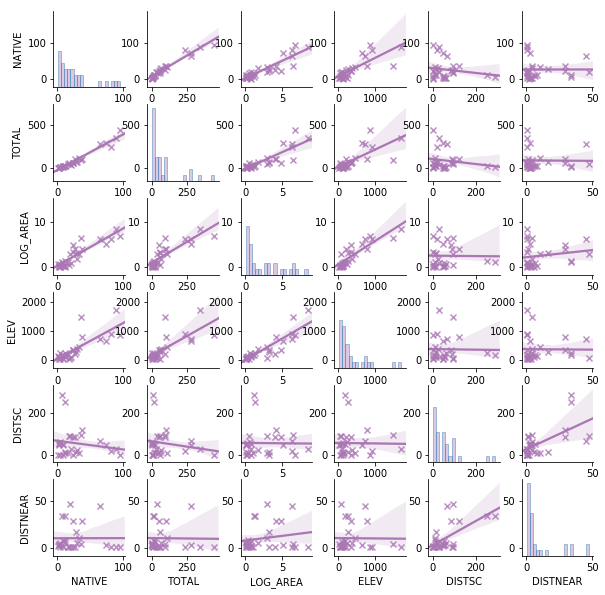

In [36]:
ax = sns.pairplot(islands, vars=['NATIVE','TOTAL','LOG_AREA','ELEV','DISTSC','DISTNEAR'],kind='reg',
             diag_kws={'linewidth':1,'alpha':.4,'edgecolor':'#1f77b4','bins':20,'color':'#aa77b4'},
             plot_kws={'marker':"x",'color':'#aa77b4'})
ax.fig.set_size_inches(8,8)
plot_images(plt,'4_21')

In [19]:
N_TEST = 8
test_ix = np.arange(len(islands))
np.random.seed(42)
np.random.shuffle(test_ix)
islands_test = islands.drop(islands.index[test_ix[:N_TEST]])
islands_oos = islands.iloc[test_ix[:N_TEST]]
islands_oos

ISLAND  TOTAL  NATIVE         AREA  ELEV  DISTNEAR     DISTSC  \
27       Seymour     44      16     1.840000   154       0.6   9.600000   
15       Isabela    347      89  4669.319824  1707       0.7  28.100000   
23  San Salvador    237      81   572.330017   906       0.2  19.799999   
17        Onslow      2       2     0.010000    25       3.3  45.900002   
8           Eden      8       4     0.030000    46       0.4   0.400000   
9        Enderby      2       2     0.180000   112       2.6  50.200001   
28       Tortuga     16       8     1.240000   186       6.8  50.900002   
24    Santa Cruz    444      95   903.820007   864       0.6   0.000000   

      AREANEAR  LOG_AREA  NORM_ELEV  NORM_NATIVE  NORM_LOG_AREA  NORM_TOTAL  \
27   25.090000  1.043804  -0.508988    -0.388572      -0.571993   -0.359698   
15  634.489990  8.448983   3.177853     2.312928       2.356159    2.283518   
23    4.890000  6.351461   1.276269     2.016874       1.526758    1.323935   
17    0.100000  0.009950  -0.815236    -0.906668      -0.980799   -0.726085   
8    17.950001  0.029559  -0.765382    -0.832654      -0.973045   -0.673744   
9     0.100000  0.165514  -0.608697    -0.906668      -0.919286   -0.726085   
28   17.950001  0.806476  -0.433020    -0.684627      -0.665837   -0.603956   
24    0.520000  6.807736   1.176561     2.534969       1.707178    3.129697   

    NORM_DISTNEAR  NORM_DISTSC  
27      -0.662714    -0.696385  
15      -0.655708    -0.424455  
23      -0.690736    -0.546456  
17      -0.473567    -0.162815  
8       -0.676725    -0.831614  
9       -0.522605    -0.099609  
28      -0.228377    -0.089320  
24      -0.662714    -0.837494

# basic regression

In [20]:
from statsmodels import regression
import statsmodels.formula.api as smf

In [22]:
mod = smf.ols(formula='NORM_NATIVE ~ NORM_LOG_AREA + NORM_ELEV', data=islands_test)
res = mod.fit()
print(res.summary())
oos_pred=islands_oos['NORM_LOG_AREA'].values*res.params['NORM_LOG_AREA']+islands_oos['NORM_ELEV'].values*res.params['NORM_ELEV']+res.params['Intercept']

                            OLS Regression Results                            
Dep. Variable:            NORM_NATIVE   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.614
Method:                 Least Squares   F-statistic:                     17.68
Date:                Sat, 04 Nov 2017   Prob (F-statistic):           4.60e-05
Time:                        22:51:08   Log-Likelihood:                -10.700
No. Observations:                  22   AIC:                             27.40
Df Residuals:                      19   BIC:                             30.67
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.0999      0.091     -1.093

In [23]:
log_area_s = shared(islands_test['NORM_LOG_AREA'].values)
elev_s = shared(islands_test['NORM_ELEV'].values)

with pm.Model() as model:
    a = pm.Normal('a',0,20)
    b = pm.Normal('b',0,20)
    intercept = pm.Uniform('int',-10,10)
    sigma = pm.HalfCauchy('sigma',1)
    y = pm.Normal('y', observed = islands_test['NORM_NATIVE'].values, 
                  mu=intercept+a*log_area_s+b*elev_s,
                  sd=sigma)
    
    trace = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|████████████████████████████████████████████████████████████████████████████| 5500/5500 [00:05<00:00, 1058.75it/s]


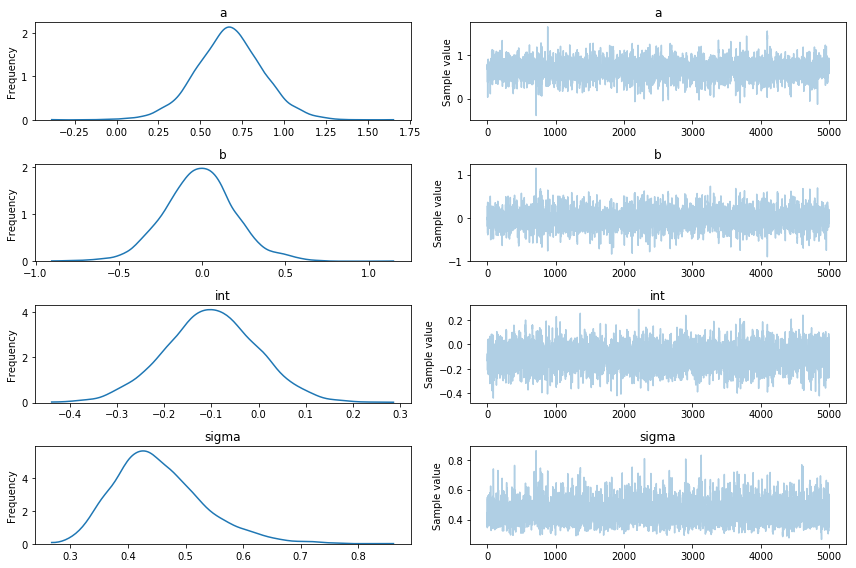

In [24]:
pm.traceplot(trace)
plt.show()

## inference

In [26]:
from pymc3 import sample_ppc

log_area_s.set_value(islands_oos['NORM_LOG_AREA'].values)
elev_s.set_value(islands_oos['NORM_ELEV'].values)

with model:
    trace_2 = sample_ppc(trace)

100%|████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 3077.83it/s]


In [32]:
denorm_trace = normed['NATIVE'].denormalize(trace_2['y'].T)

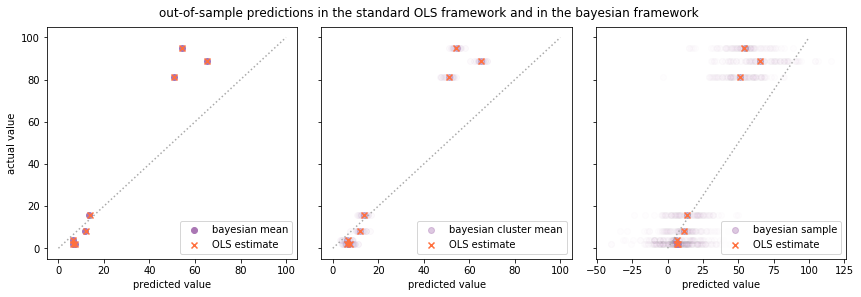

In [33]:
f, axes = plt.subplots(1,3,figsize=(12,4), sharey=True)
f.suptitle('out-of-sample predictions in the standard OLS framework and in the bayesian framework', y=1.02)

ax = axes[0]
ax.scatter(denorm_trace.mean(axis=1), islands_oos['NATIVE'].values,color='#aa77b4',alpha=1, marker='o', label='bayesian mean')
ax.scatter(normed['NATIVE'].denormalize(oos_pred), islands_oos['NATIVE'].values, marker='x', label='OLS estimate', color='#FF703E')
ax.plot([0,100],[0,100], ':', color='darkgrey')
ax.legend(loc=4)
ax.set_ylabel('actual value')
ax.set_xlabel('predicted value')

ax = axes[1]
CLUSTER = 50
ax.scatter(denorm_trace.mean(axis=1), islands_oos['NATIVE'].values, color='#aa77b4',alpha=.4,label='bayesian cluster mean')
for j in range(100,1000,CLUSTER):
    ax.scatter(denorm_trace.T[j:j+CLUSTER].mean(axis=0), islands_oos['NATIVE'].values, color='#aa77b4',alpha=.03)
ax.scatter(normed['NATIVE'].denormalize(oos_pred), islands_oos['NATIVE'].values, marker='x', label='OLS estimate', color='#FF703E')
ax.plot([0,100],[0,100], ':', color='darkgrey')
ax.legend(loc=4)
ax.set_xlabel('predicted value')

ax = axes[2]
CLUSTER = 1
ax.scatter(denorm_trace.mean(axis=1), islands_oos['NATIVE'].values, color='#aa77b4',alpha=.4,label='bayesian sample')
for j in range(100,200,CLUSTER):
    ax.scatter(denorm_trace.T[j:j+CLUSTER].mean(axis=0), islands_oos['NATIVE'].values, color='#aa77b4',alpha=.01)
ax.scatter(normed['NATIVE'].denormalize(oos_pred), islands_oos['NATIVE'].values, marker='x', label='OLS estimate', color='#FF703E')
ax.plot([0,100],[0,100], ':', color='darkgrey')
ax.legend(loc=4)
ax.set_xlabel('predicted value')

plt.tight_layout()
plot_images(plt,'4_22')

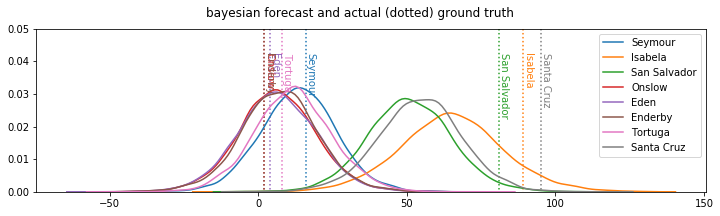

In [34]:
plt.figure(figsize=(12,3))
plt.suptitle('bayesian forecast and actual (dotted) ground truth')
for i,tr in enumerate(denorm_trace):
    g = sns.distplot(tr, hist=False, label=str(islands_oos['ISLAND'].iloc[i]))
    plt.vlines(islands_oos['NATIVE'].iloc[i],.1,0,linestyles=':', color=g.get_lines()[i].get_color())
    plt.text(islands_oos['NATIVE'].iloc[i],.04,str(islands_oos['ISLAND'].iloc[i]), rotation=-90, color=g.get_lines()[i].get_color())
plt.ylim(0,.05)
plot_images(plt,'4_23')

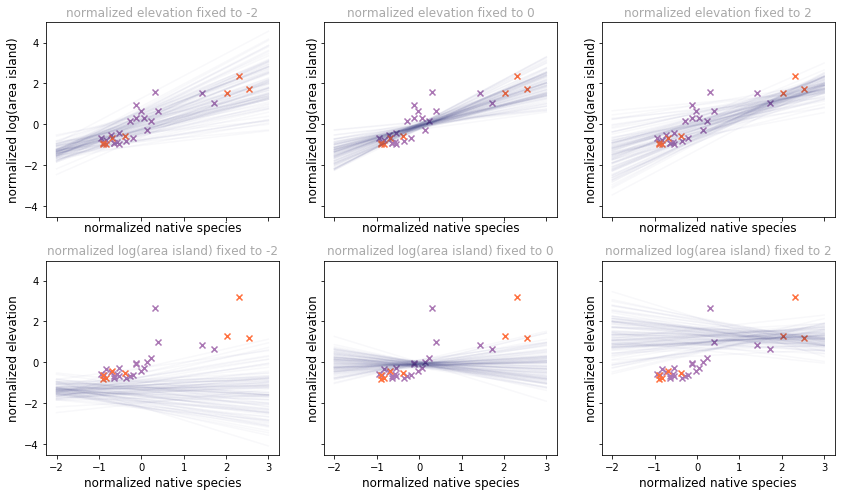

In [35]:
fig, axes = plt.subplots(2,3,figsize=(12,7), sharex=True, sharey=True)

fixed = [-2,0,2]

for j, ax in enumerate(axes[0]):
    for i in np.arange(len(trace['a']))[2000:2100]:
        z=np.linspace(-2,3,2)
        ax.plot(z,trace['a'][i]*z+trace['int'][i]+trace['b'][i]*fixed[j], color='#2E317F', alpha=.03)
    ax.set_title('normalized elevation fixed to '+str(fixed[j]), color='darkgrey')
    ax.scatter(islands_test['NORM_NATIVE'].values,islands_test['NORM_LOG_AREA'].values, marker='x', label='train set', color='#aa77b4')
    ax.scatter(islands_oos['NORM_NATIVE'].values,islands_oos['NORM_LOG_AREA'].values, marker='x', label='test set', color='#FF703E')
    ax.set_ylabel('normalized log(area island)',size=12)
    ax.set_xlabel('normalized native species',size=12)
    
for j, ax in enumerate(axes[1]):
    for i in np.arange(len(trace['a']))[2000:2100]:
        z=np.linspace(-2,3,2)
        ax.plot(z,trace['a'][i]*fixed[j]+trace['int'][i]+trace['b'][i]*z, color='#2E317F', alpha=.03)
    ax.set_title('normalized log(area island) fixed to '+str(fixed[j]), color='darkgrey')
    ax.scatter(islands_test['NORM_NATIVE'].values,islands_test['NORM_ELEV'].values, marker='x', label='train set', color='#aa77b4')
    ax.scatter(islands_oos['NORM_NATIVE'].values,islands_oos['NORM_ELEV'].values, marker='x', label='test set', color='#FF703E')
    ax.set_ylabel('normalized elevation',size=12)
    ax.set_xlabel('normalized native species',size=12)
plt.tight_layout()
#plt.legend()
plot_images(plt,'4_24')